In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary 
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [2]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device,"is being used")

cuda is being used


In [3]:
torch.manual_seed(42)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([transforms.RandomRotation(10),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


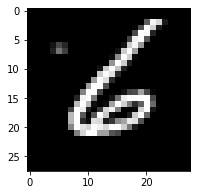

tensor(6)

In [4]:
images, labels = next(iter(train_loader))
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[5])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.show()
labels[5]

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
            #input-28x28x1
        self.conv1 = nn.Sequential(
            # RF - 3x3
            nn.Conv2d(1, 16, 3, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),          
            nn.Dropout2d(0.1),

            #input-26x26x16
            # RF - 5x5
            nn.Conv2d(16, 16, 3, bias=False),   
            nn.BatchNorm2d(16),                   
            nn.ReLU(),           
            
            #input-24x24x16
            # RF - 7x7
            nn.Conv2d(16, 32, 3, bias=False),    
            nn.BatchNorm2d(32),        
            nn.ReLU(),           
            nn.Dropout2d(0.1),
        )

        
        #Transition block
        self.transition= nn.Sequential(
            #input-22x22x32
            nn.Conv2d(32,16,1),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),
            #output=11x11x16
        )      

        self.conv2 = nn.Sequential(
            
            #input=11x11x16
            nn.Conv2d(16, 16, 3, bias=False), #RF=16x16       
            nn.BatchNorm2d(16),   
            nn.ReLU(),             
            nn.Dropout2d(0.1), 

            #input=9x9x16
            nn.Conv2d(16, 16, 3, padding=1, bias=False),        
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(16, 16, 3,bias=False),   
            nn.BatchNorm2d(16),            
            nn.ReLU(),
            nn.Dropout2d(0.1),
            
            #input=7x7x16
            nn.Conv2d(16,32, 3, bias=False),  
            nn.BatchNorm2d(32),  
            nn.ReLU(),
            nn.Dropout2d(0.1),        

        )   #output=5x5x32

        self.conv_final=nn.Conv2d(32, 10, 1, bias=False)# input: 32x5x5, output: 32x1x1 
        self.gap = nn.AvgPool2d(5)            
            

    def forward(self, x):

        x= self.conv1(x)
        x=self.transition(x)
        x= self.conv2(x)      
        x=self.conv_final(x)
        x=self.gap(x)
        x=x.view(-1,10)        
        
        return F.log_softmax(x)

In [6]:
# model the model to the device
model = Net().to(device)
# print the model summary when given input_size
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
            Conv2d-8           [-1, 32, 22, 22]           4,608
       BatchNorm2d-9           [-1, 32, 22, 22]              64
             ReLU-10           [-1, 32, 22, 22]               0
        Dropout2d-11           [-1, 32, 22, 22]               0
           Conv2d-12           [-1, 16, 22, 22]             528
             ReLU-13           [-1, 16, 22, 22]               0
        MaxPool2d-14           [-1, 16,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [7]:

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)


for epoch in range(1, 21):
    print('\nEpoch {} : '.format(epoch))
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


Epoch 1 : 


loss=0.09951310604810715 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]



Test set: Average loss: 0.0502, Accuracy: 9858/10000 (98.58%)


Epoch 2 : 


loss=0.12439335137605667 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]



Test set: Average loss: 0.0443, Accuracy: 9845/10000 (98.45%)


Epoch 3 : 


loss=0.11283024400472641 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]



Test set: Average loss: 0.0350, Accuracy: 9900/10000 (99.00%)


Epoch 4 : 


loss=0.15605205297470093 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]



Test set: Average loss: 0.0316, Accuracy: 9899/10000 (98.99%)


Epoch 5 : 


loss=0.14872819185256958 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]



Test set: Average loss: 0.0282, Accuracy: 9905/10000 (99.05%)


Epoch 6 : 


loss=0.07366801053285599 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]



Test set: Average loss: 0.0295, Accuracy: 9907/10000 (99.07%)


Epoch 7 : 


loss=0.07596011459827423 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]



Test set: Average loss: 0.0281, Accuracy: 9915/10000 (99.15%)


Epoch 8 : 


loss=0.010262154042720795 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]



Test set: Average loss: 0.0260, Accuracy: 9921/10000 (99.21%)


Epoch 9 : 


loss=0.09185423702001572 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]



Test set: Average loss: 0.0236, Accuracy: 9921/10000 (99.21%)


Epoch 10 : 


loss=0.08244063705205917 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]



Test set: Average loss: 0.0261, Accuracy: 9919/10000 (99.19%)


Epoch 11 : 


loss=0.011143454350531101 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]



Test set: Average loss: 0.0234, Accuracy: 9924/10000 (99.24%)


Epoch 12 : 


loss=0.045645054429769516 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.36it/s]



Test set: Average loss: 0.0279, Accuracy: 9913/10000 (99.13%)


Epoch 13 : 


loss=0.013037172146141529 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.35it/s]



Test set: Average loss: 0.0276, Accuracy: 9920/10000 (99.20%)


Epoch 14 : 


loss=0.0418940968811512 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]



Test set: Average loss: 0.0232, Accuracy: 9922/10000 (99.22%)


Epoch 15 : 


loss=0.034113917499780655 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]



Test set: Average loss: 0.0212, Accuracy: 9939/10000 (99.39%)


Epoch 16 : 


loss=0.009824828244745731 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]



Test set: Average loss: 0.0231, Accuracy: 9934/10000 (99.34%)


Epoch 17 : 


loss=0.04727235436439514 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]



Test set: Average loss: 0.0182, Accuracy: 9940/10000 (99.40%)


Epoch 18 : 


loss=0.026582667604088783 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]



Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)


Epoch 19 : 


loss=0.03843732550740242 batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.54it/s]



Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)


Epoch 20 : 


loss=0.0451742447912693 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]



Test set: Average loss: 0.0171, Accuracy: 9949/10000 (99.49%)

